In [14]:
import duckdb
from pipelines.tasks._common import DUCKDB_FILE

con = duckdb.connect(database=DUCKDB_FILE, read_only=True)

import pandas as pd
import os
import numpy as np

query = """
SELECT edc_prelevements.dateprel, edc_prelevements.heureprel,edc_prelevements.inseecommuneprinc, edc_prelevements.nomcommuneprinc, edc_prelevements.cdreseau, edc_prelevements.cdreseauamont, edc_resultats.*
FROM edc_prelevements
JOIN edc_resultats
ON edc_prelevements.referenceprel = edc_resultats.referenceprel
WHERE
(dateprel >= '2020-01-01')
AND
(cdparametre IN (1369,1376,1385,1388,1389,1387,1382,1386,1392,7074,2542,1371,1382,5903,5904,1369,1380,1388,1376,1392,1386,1389,1387,1385,1928))
AND
(cdreseauamont is NULL)
"""

res = con.sql(query)
res = res.df()


Choses à faire :

Isoler les prélèvements de ces familles grâce à la catégorisation de Pauline (“Métaux Lourds”, “Sous produits de désinfection”, “PCB”, “Phtalates”, “HAP”)

Répondre aux questions

Combien de fois les paramètres ont été recherchés par an dans la France entière

Est-ce qu’il y a eu des recherches dans toutes les régions? Sinon, dans quelles régions ils ont été recherchés? (pas besoin de descendre à la commune à ce stade).

Pour chaque paramètre, quelle est la fréquence de quantification? (nombre de fois que le paramètre a été quantifié / nombre de fois que le paramètre est recherché dans l’année sur la France entière) (quantification = ’une concentration dans l’eau a pu être mesurée. Je ne sais pas comment cela se traduit dans les tableaux de résultats)

Lesquels sont associés dans la base de données à une limite de qualité et quelle est la valeur de la limite de qualité indiquée? (je vérifierai si ça concorde bien avec les arrêtés)

Pour ceux avec une limite de qualité, quelle est la fréquence de dépassement de cette limite par an? (nombre de fois qu’il y a un dépassement / nombre de fois que le paramètre est recherché dans l’année sur la France entière)

Résumer cela dans un tableau outline avec ça comme colonnes:

Nom du paramètre

Nombre de recherche par an France Entière

Dans quelles régions est-il recherché?

Fréquence de quantification

Fréquence de dépassement de la limite de qualité (si existante)

Valeur de la limite de qualité


# Historique des analyses par an et par paramètre


In [16]:
res["libminparametre"].unique()

array(['Dibutylétain cation', 'Cadmium', 'Chrome total', 'Cuivre',
       'Nickel', 'Antimoine', 'Plomb', 'Arsenic', 'Mercure', 'Sélénium',
       'Chrome hexavalent', 'Arsenic dissous', 'Monobutylétain cation',
       'Etain', 'Sélénium si conditions géologiques particulières',
       'Plomb dissous', 'Monobutylétain cation (pesticide)',
       'Branchement public en plomb', 'Canali. intérieure en plomb',
       'Cuivre dissous', 'Antimoine dissous', 'Cadmium dissous',
       'Nickel dissous', 'Chrome dissous', 'Mercure dissous',
       'Sélénium dissous', 'Étain dissous'], dtype=object)

In [17]:
res[["cdparametre", "libminparametre", "limitequal"]].drop_duplicates()

,cdparametre,libminparametre,limitequal
0,7074,Dibutylétain cation,"<=0,1 µg/L"
1,1388,Cadmium,<=5 µg/L
2,1389,Chrome total,<=50 µg/L
3,1392,Cuivre,<=2 mg/L
4,1386,Nickel,<=20 µg/L
5,1376,Antimoine,<=10 µg/L
10,1382,Plomb,<=10 µg/L
195,1369,Arsenic,<=10 µg/L
196,1387,Mercure,<=1 µg/L
197,1385,Sélénium,<=20 µg/L


On va compter combien de prélèvements ont été faits par paramètre et par année depuis 2020


In [29]:
query_countglobal = """SELECT cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(referenceprel) AS Count, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre, Annee
ORDER BY cdparametre,Annee"""

countglobal = con.sql(query_countglobal)
countglobal = countglobal.df()

In [38]:
countglobal.head(20)

,cdparametre,libminparametre,Count,Annee
0,1369,Arsenic,3072,2020
1,1369,Arsenic,3536,2021
2,1369,Arsenic,3587,2022
3,1369,Arsenic,3462,2023
4,1369,Arsenic,3518,2024
5,1371,Chrome hexavalent,36,2020
6,1371,Chrome hexavalent,1017,2021
7,1371,Chrome hexavalent,1177,2022
8,1371,Chrome hexavalent,1174,2023
9,1371,Chrome hexavalent,1175,2024


In [ ]:
countglobal[
    (countglobal["Annee"] == 2020) & (countglobal["cdparametre"] == 1380)
].Count.iloc[0]

np.int64(30)

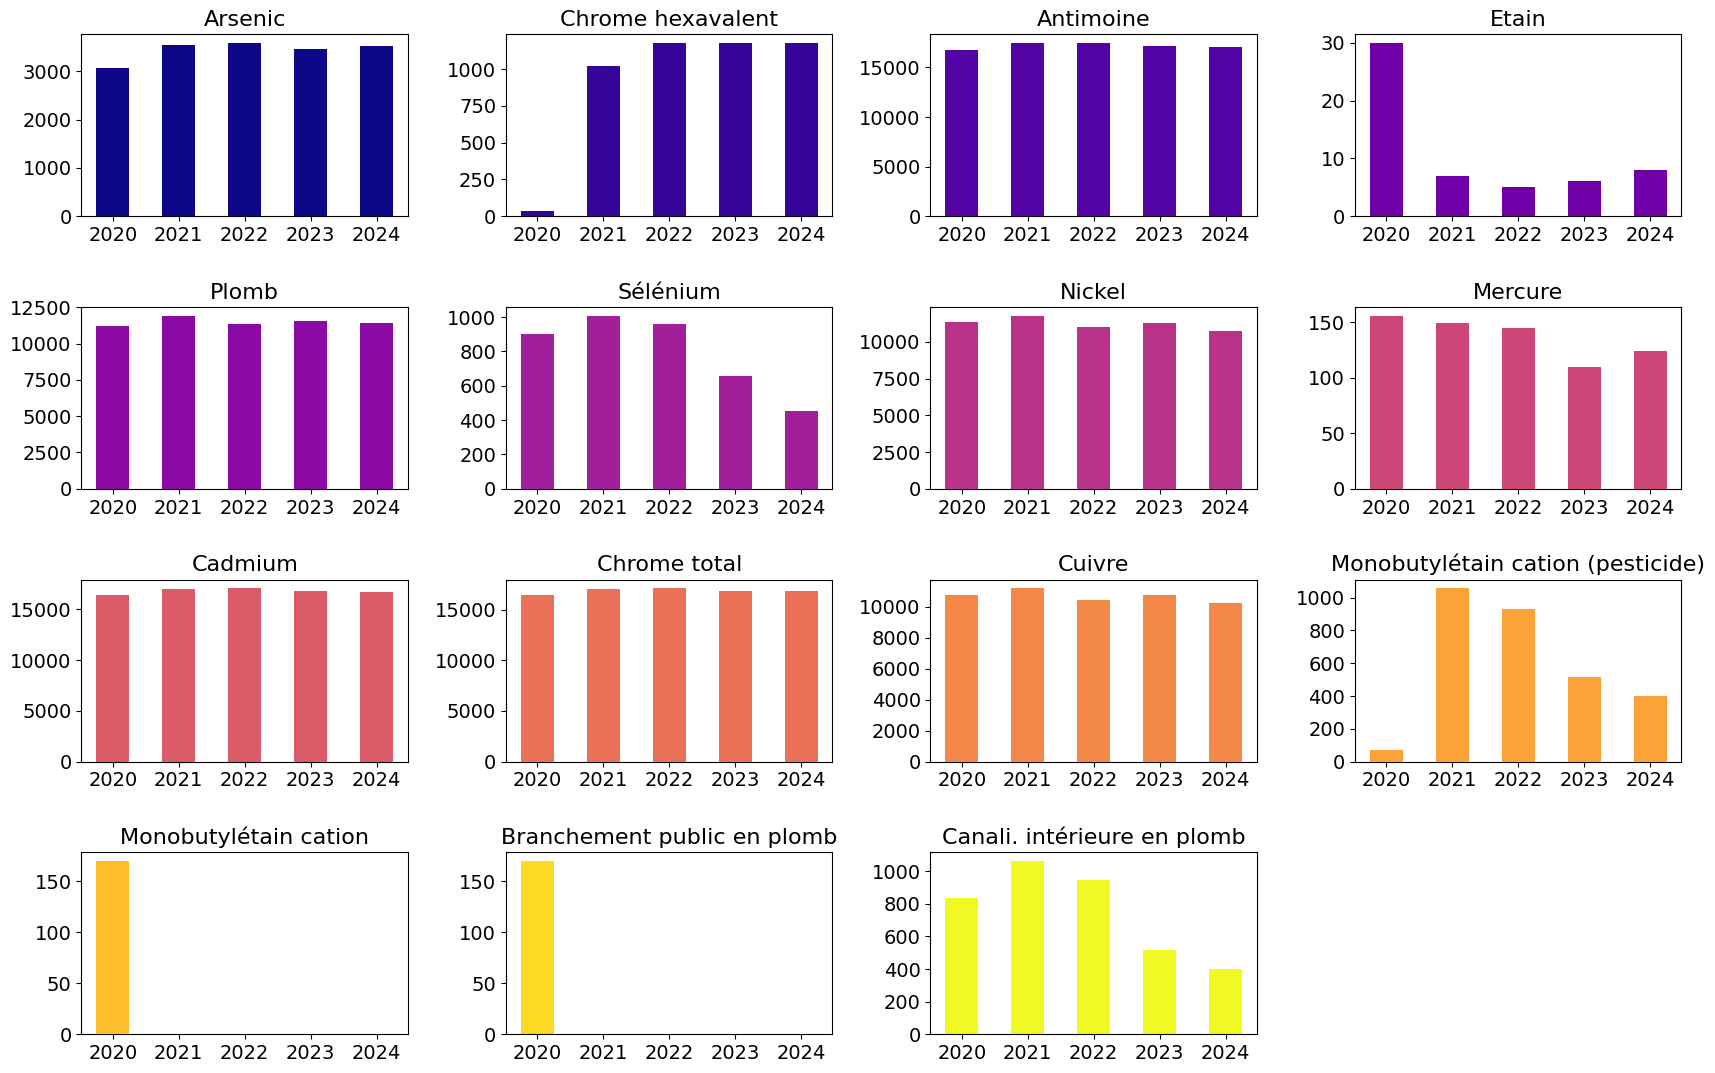

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

barWidth = 0.5

y = [2020, 2021, 2022, 2023, 2024]
y_data = []
aux = []
y_libminparametre = countglobal["libminparametre"].unique()
y_cdparametre = countglobal["cdparametre"].unique()
nb_param = len(y_cdparametre)

# On liste par annee le count de chaque parametre

for k in y_cdparametre:
    for m in y:
        arraux = countglobal[
            (countglobal["Annee"] == m) & (countglobal["cdparametre"] == k)
        ]["Count"]
        if len(arraux) > 0:
            aux.append(arraux.iloc[0])
        else:
            aux.append(0)
    y_data.append(aux)
    aux = []

br = [np.arange(len(y_data[0]))]

# for k in range(nb_param):
#    br.append([x + barWidth for x in br[k]])

f = plt.figure(figsize=(16, 10))
color = matplotlib.colormaps["plasma"]

for k in range(nb_param):
    plt.subplot(4, 4, k + 1)
    plt.bar(
        y,
        y_data[k],
        color=color(k / (nb_param - 1)),
        width=barWidth,
        zorder=nb_param - k,
        alpha=1.0,
    )
    plt.title(y_libminparametre[k], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0, right=1, bottom=0, top=1)
plt.show()

# Historique des recherches par région pour l'ensemble des métaux lourds


In [97]:
import geopandas as gpd

In [ ]:
region = gpd.read_file(r"C:\Users\Admin\Downloads\regions-version-simplifiee.geojson")

In [ ]:
geo = pd.read_csv(r"C:\Users\Admin\Downloads\20230823-communes-departement-region.csv")
geo_clean = geo.dropna(subset=["code_region"])
geo_clean["code_region"] = geo_clean["code_region"].astype(int)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8988\1780360425.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_clean["code_region"] = geo_clean["code_region"].astype(int)


In [106]:
geo_clean.head()

,code_commune_INSEE,nom_commune_postal,code_postal,libelle_acheminement,ligne_5,latitude,longitude,code_commune,article,nom_commune,nom_commune_complet,code_departement,nom_departement,code_region,nom_region
0,1001,L ABERGEMENT CLEMENCIAT,1400,L ABERGEMENT CLEMENCIAT,NaN,46.153426,4.926114,1.0,L',Abergement-Clémenciat,L'Abergement-Clémenciat,1,Ain,84,Auvergne-Rhône-Alpes
1,1002,L ABERGEMENT DE VAREY,1640,L ABERGEMENT DE VAREY,NaN,46.009188,5.428017,2.0,L',Abergement-de-Varey,L'Abergement-de-Varey,1,Ain,84,Auvergne-Rhône-Alpes
2,1004,AMBERIEU EN BUGEY,1500,AMBERIEU EN BUGEY,NaN,45.960848,5.372926,4.0,NaN,Ambérieu-en-Bugey,Ambérieu-en-Bugey,1,Ain,84,Auvergne-Rhône-Alpes
3,1005,AMBERIEUX EN DOMBES,1330,AMBERIEUX EN DOMBES,NaN,45.996180,4.912273,5.0,NaN,Ambérieux-en-Dombes,Ambérieux-en-Dombes,1,Ain,84,Auvergne-Rhône-Alpes
4,1006,AMBLEON,1300,AMBLEON,NaN,45.749499,5.594320,6.0,NaN,Ambléon,Ambléon,1,Ain,84,Auvergne-Rhône-Alpes


In [130]:
query_region = """SELECT COUNT(referenceprel) AS Count, year(dateprel) AS Annee, ANY_VALUE(geo_clean.code_region) AS code_region, ANY_VALUE(geo_clean.nom_region) AS nom_region
FROM res
JOIN geo_clean
ON res.inseecommuneprinc=geo_clean.code_commune_INSEE
GROUP BY Annee,code_region
ORDER BY code_region,Annee"""

res_region = con.sql(query_region)
res_region = res_region.df()

In [131]:
res_region.head(15)

,Count,Annee,code_region,nom_region
0,468,2020,1,Guadeloupe
1,699,2021,1,Guadeloupe
2,667,2022,1,Guadeloupe
3,606,2023,1,Guadeloupe
4,516,2024,1,Guadeloupe
5,332,2020,2,Martinique
6,414,2021,2,Martinique
7,456,2022,2,Martinique
8,252,2023,2,Martinique
9,378,2024,2,Martinique


In [ ]:
# Plot cartographie par année

In [ ]:
region["code"] = region["code"].astype(int)

In [132]:
res_region_carto = region.join(res_region.set_index("code_region"), on="code")

In [133]:
res_region_carto = res_region_carto.set_geometry("geometry")

# Cartographie du nombre de prélèvements par année et par région pour l'ensemble de la catégorie métaux lourds


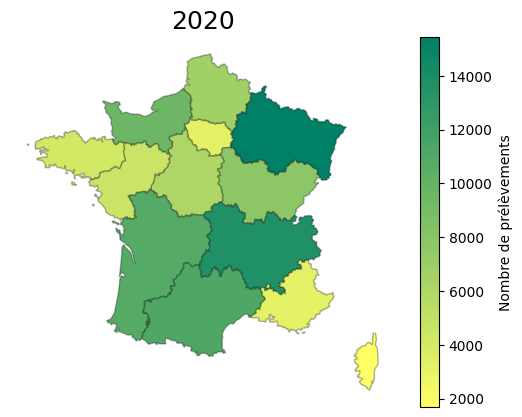

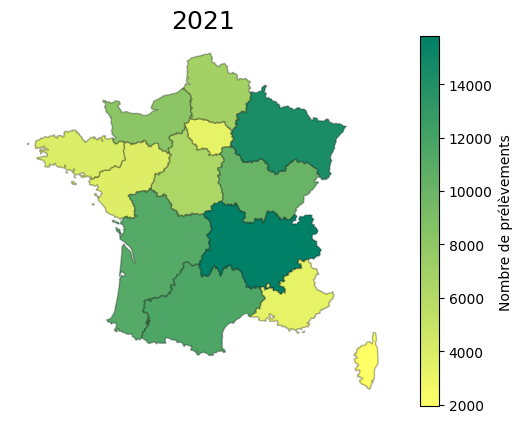

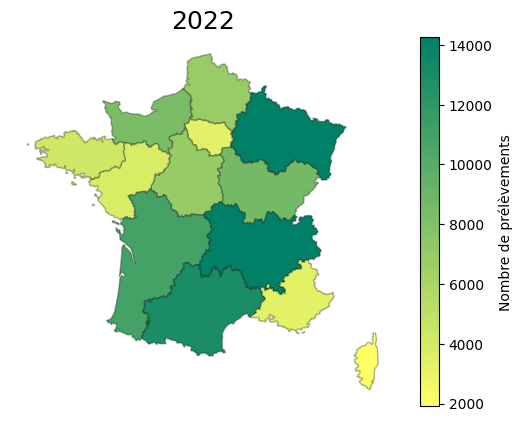

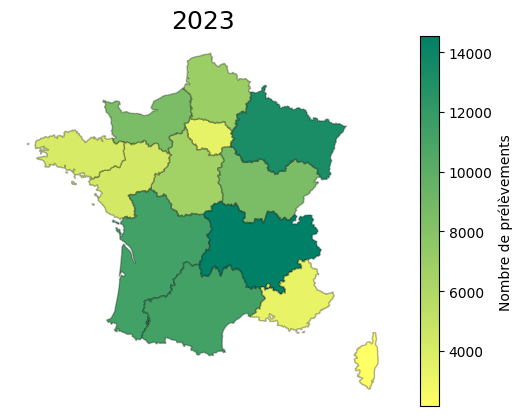

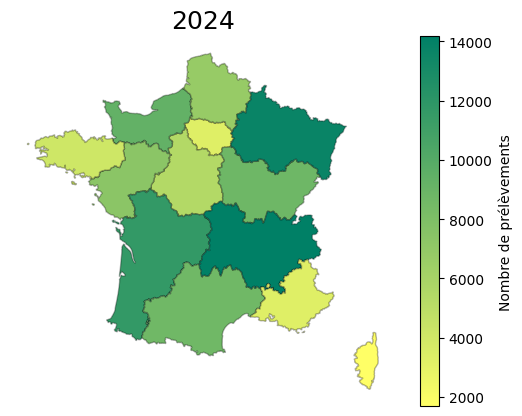

In [ ]:
for k in range(len(y)):
    # remove frame from each side of plot
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    res_region_carto[res_region_carto["Annee"] == y[k]].plot(
        column="Count",
        legend=True,
        cmap="summer_r",
        edgecolor=(0, 0, 0, 0.3),
        legend_kwds={"label": "Nombre de prélèvements"},
    )
    plt.xticks([])
    plt.yticks([])

    plt.title(str(y[k]), fontsize=18)

# Etude par région pour chaque paramètre


In [180]:
query_region_param = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(referenceprel) AS Count, year(dateprel) AS Annee, ANY_VALUE(geo_clean.code_region) AS code_region, ANY_VALUE(geo_clean.nom_region) AS nom_region
FROM res
JOIN geo_clean
ON res.inseecommuneprinc=geo_clean.code_commune_INSEE
GROUP BY cdparametre,Annee,code_region
ORDER BY cdparametre,code_region,Annee"""

res_region_param = con.sql(query_region_param)
res_region_param = res_region_param.df()

In [181]:
res_region_param

,cdparametre,libminparametre,Count,Annee,code_region,nom_region
0,1369,Arsenic,3,2020,1,Guadeloupe
1,1369,Arsenic,13,2021,1,Guadeloupe
2,1369,Arsenic,4,2022,1,Guadeloupe
3,1369,Arsenic,2,2024,1,Guadeloupe
4,1369,Arsenic,1,2022,6,Mayotte
...,...,...,...,...,...,...
766,7074,Dibutylétain cation,546,2023,27,Bourgogne-Franche-Comté
767,7074,Dibutylétain cation,451,2024,27,Bourgogne-Franche-Comté
768,7074,Dibutylétain cation,2,2020,44,Grand Est
769,7074,Dibutylétain cation,2,2022,44,Grand Est


# Fréquence de quantification de chaque paramètre


In [188]:
query_tot = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(referenceprel) AS Count_total, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre,Annee
ORDER BY cdparametre,Annee"""

res_tot = con.sql(query_tot)
res_tot = res_tot.df()

In [189]:
res_tot.head(20)

,cdparametre,libminparametre,Count_total,Annee
0,1369,Arsenic,3072,2020
1,1369,Arsenic,3536,2021
2,1369,Arsenic,3587,2022
3,1369,Arsenic,3462,2023
4,1369,Arsenic,3518,2024
5,1371,Chrome hexavalent,36,2020
6,1371,Chrome hexavalent,1017,2021
7,1371,Chrome hexavalent,1177,2022
8,1371,Chrome hexavalent,1174,2023
9,1371,Chrome hexavalent,1175,2024


In [209]:
query_quantif = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(CASE WHEN valtraduite!=0 THEN 1 END) AS Count_quantif, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre,Annee
ORDER BY cdparametre,Annee"""

res_quantif = con.sql(query_quantif)
res_quantif = res_quantif.df()

In [216]:
res_quantif.head(5)

,cdparametre,libminparametre,Count_quantif,Annee
0,1369,Arsenic,2394,2020
1,1369,Arsenic,2539,2021
2,1369,Arsenic,2630,2022
3,1369,Arsenic,2540,2023
4,1369,Arsenic,2586,2024


In [212]:
res_quantification = res_tot.assign(
    Taux_quantification=np.divide(res_quantif.Count_quantif, res_tot.Count_total)
)

In [215]:
res_quantification.head(5)

,cdparametre,libminparametre,Count_total,Annee,Taux_quantification
0,1369,Arsenic,3072,2020,0.779297
1,1369,Arsenic,3536,2021,0.718043
2,1369,Arsenic,3587,2022,0.733203
3,1369,Arsenic,3462,2023,0.733680
4,1369,Arsenic,3518,2024,0.735077


Fréquence de quantification


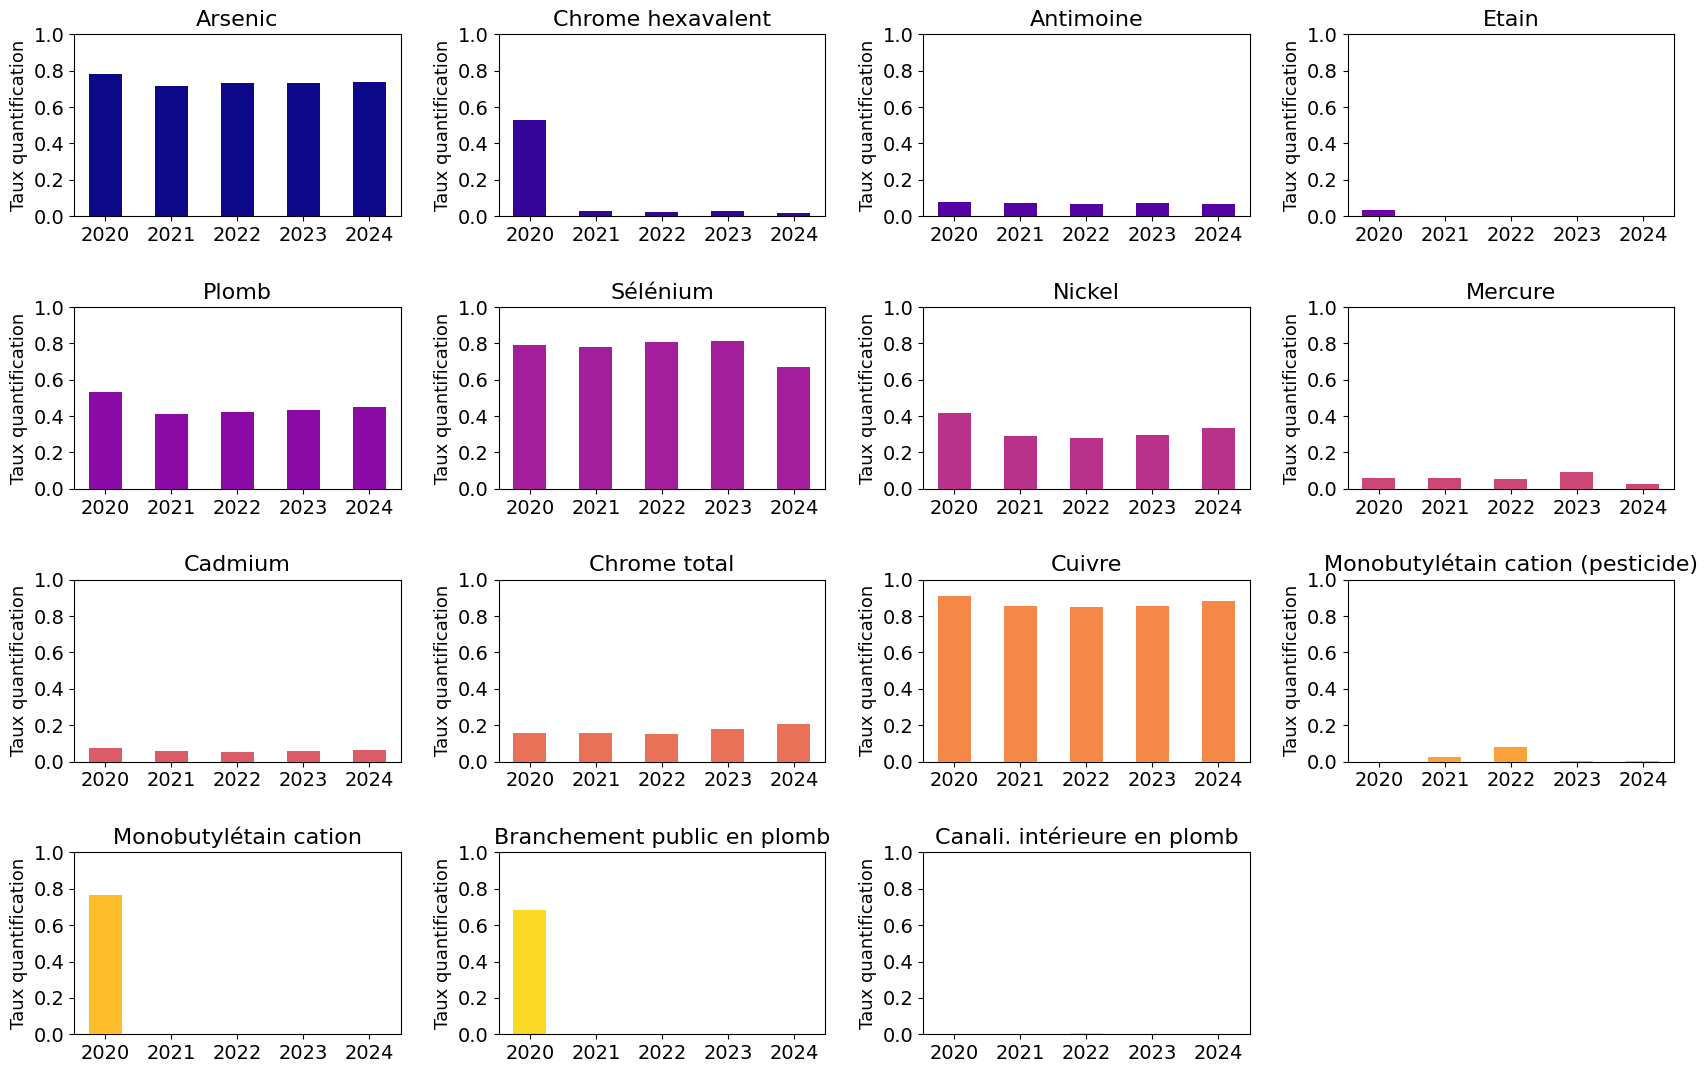

In [ ]:
print("Fréquence de quantification")
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.bottom"] = True

barWidth = 0.5

y = [2020, 2021, 2022, 2023, 2024]
y_data = []
aux = []
y_libminparametre = res_quantification["libminparametre"].unique()
y_cdparametre = res_quantification["cdparametre"].unique()
nb_param = len(y_cdparametre)

# On liste par annee le count de chaque parametre

for k in y_cdparametre:
    for m in y:
        arraux = res_quantification[
            (res_quantification["Annee"] == m)
            & (res_quantification["cdparametre"] == k)
        ]["Taux_quantification"]
        if len(arraux) > 0:
            aux.append(arraux.iloc[0])
        else:
            aux.append(0)
    y_data.append(aux)
    aux = []

br = [np.arange(len(y_data[0]))]

# for k in range(nb_param):
#    br.append([x + barWidth for x in br[k]])

f = plt.figure(figsize=(16, 10))
color = matplotlib.colormaps["plasma"]

for k in range(nb_param):
    plt.subplot(4, 4, k + 1)
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.bar(
        y,
        y_data[k],
        color=color(k / (nb_param - 1)),
        width=barWidth,
        zorder=nb_param - k,
        alpha=1.0,
    )
    plt.title(y_libminparametre[k], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Taux quantification", fontsize=13)

plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0, right=1, bottom=0, top=1)
plt.show()

# Fréquence de dépassement


In [249]:
query_dep = """SELECT ANY_VALUE(cdparametre) AS cdparametre, ANY_VALUE(libminparametre) AS libminparametre, COUNT(CASE WHEN valtraduite > CAST(regexp_extract("limitequal", '[0-9]+') AS INT) THEN 1 END) AS Count_dep, year(dateprel) AS Annee
FROM res
GROUP BY cdparametre,Annee
ORDER BY cdparametre,Annee"""

res_dep = con.sql(query_dep)
res_dep = res_dep.df()

In [250]:
res_dep.head(5)

,cdparametre,libminparametre,Count_dep,Annee
0,1369,Arsenic,141,2020
1,1369,Arsenic,138,2021
2,1369,Arsenic,158,2022
3,1369,Arsenic,164,2023
4,1369,Arsenic,124,2024


In [251]:
res_tauxdep = res_tot.assign(
    Taux_depassement=np.divide(res_dep.Count_dep, res_tot.Count_total)
)

Fréquence de dépassement


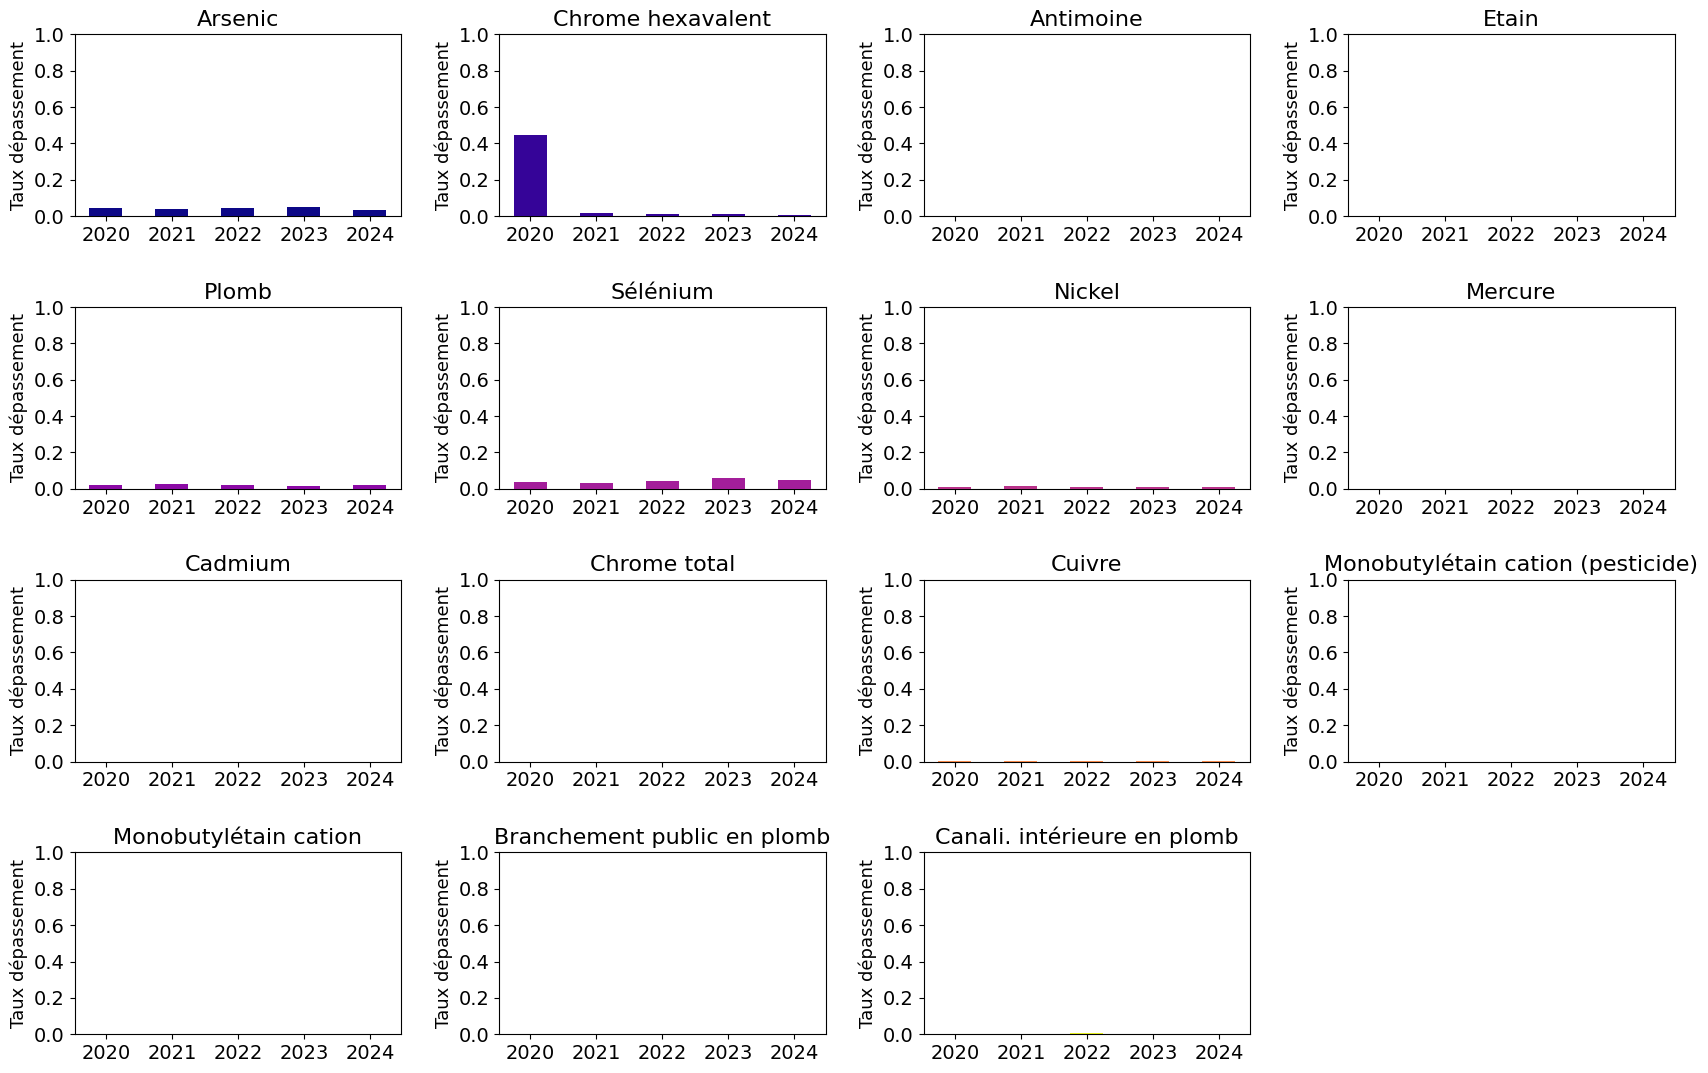

In [ ]:
print("Fréquence de dépassement")
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.bottom"] = True

barWidth = 0.5

y = [2020, 2021, 2022, 2023, 2024]
y_data = []
aux = []
y_libminparametre = res_tauxdep["libminparametre"].unique()
y_cdparametre = res_tauxdep["cdparametre"].unique()
nb_param = len(y_cdparametre)

# On liste par annee le count de chaque parametre

for k in y_cdparametre:
    for m in y:
        arraux = res_tauxdep[
            (res_tauxdep["Annee"] == m) & (res_tauxdep["cdparametre"] == k)
        ]["Taux_depassement"]
        if len(arraux) > 0:
            aux.append(arraux.iloc[0])
        else:
            aux.append(0)
    y_data.append(aux)
    aux = []

br = [np.arange(len(y_data[0]))]

# for k in range(nb_param):
#    br.append([x + barWidth for x in br[k]])

f = plt.figure(figsize=(16, 10))
color = matplotlib.colormaps["plasma"]

for k in range(nb_param):
    plt.subplot(4, 4, k + 1)
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.bar(
        y,
        y_data[k],
        color=color(k / (nb_param - 1)),
        width=barWidth,
        zorder=nb_param - k,
        alpha=1.0,
    )
    plt.title(y_libminparametre[k], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("Taux dépassement", fontsize=13)

plt.subplots_adjust(wspace=0.3, hspace=0.5, left=0, right=1, bottom=0, top=1)
plt.show()

# Fréquence de dépassement par année et par région


In [270]:
query_region_dep = """SELECT COUNT(CASE WHEN valtraduite > CAST(regexp_extract("limitequal", '[0-9]+') AS INT) THEN 1 END) AS Count_dep, COUNT(referenceprel) AS Count_tot, year(dateprel) AS Annee, ANY_VALUE(geo_clean.code_region) AS code_region, ANY_VALUE(geo_clean.nom_region) AS nom_region
FROM res
JOIN geo_clean
ON res.inseecommuneprinc=geo_clean.code_commune_INSEE
GROUP BY Annee,code_region
ORDER BY code_region,Annee"""

res_region_dep = con.sql(query_region_dep)
res_region_dep = res_region_dep.df()

In [271]:
res_region_dep

,Count_dep,Count_tot,Annee,code_region,nom_region
0,3,468,2020,1,Guadeloupe
1,0,699,2021,1,Guadeloupe
2,0,667,2022,1,Guadeloupe
3,0,606,2023,1,Guadeloupe
4,0,516,2024,1,Guadeloupe
...,...,...,...,...,...
85,38,1698,2020,94,Corse
86,36,1946,2021,94,Corse
87,36,1901,2022,94,Corse
88,41,2153,2023,94,Corse


In [272]:
res_region_dep = res_region_dep.assign(
    Taux_depassement=np.divide(res_region_dep.Count_dep, res_region_dep.Count_tot)
)

In [275]:
res_region_dep = region.join(res_region_dep.set_index("code_region"), on="code")
res_region_dep = res_region_dep.set_geometry("geometry")

Cartographie du taux de dépassement pour les métaux lourds à l'échelle régionale


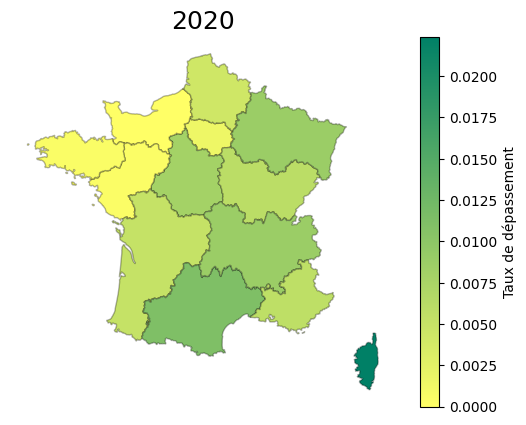

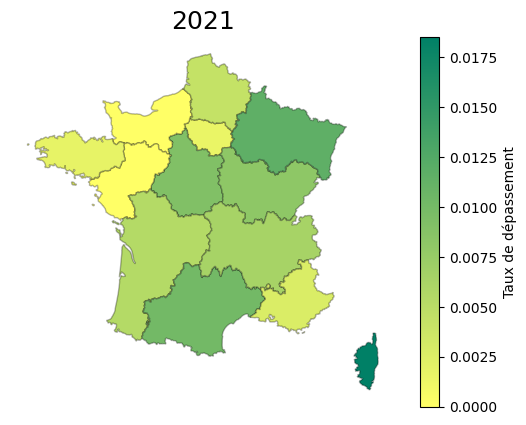

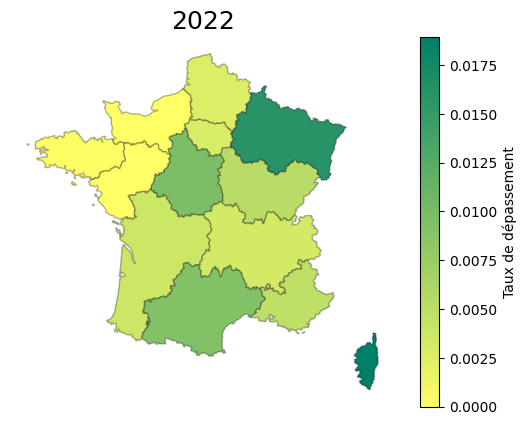

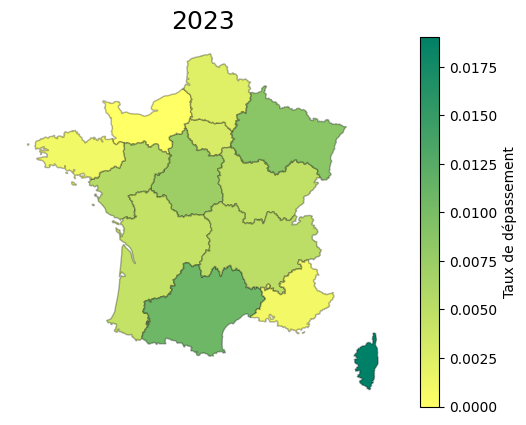

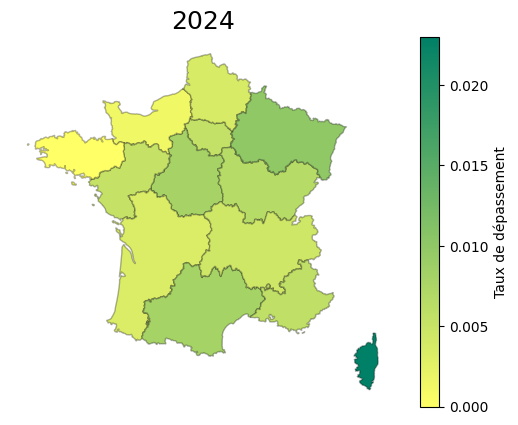

In [ ]:
print(
    "Cartographie du taux de dépassement pour les métaux lourds à l'échelle régionale"
)
for k in range(len(y)):
    # remove frame from each side of plot
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    res_region_dep[res_region_dep["Annee"] == y[k]].plot(
        column="Taux_depassement",
        legend=True,
        cmap="summer_r",
        edgecolor=(0, 0, 0, 0.3),
        legend_kwds={"label": "Taux de dépassement"},
    )
    plt.xticks([])
    plt.yticks([])

    plt.title(str(y[k]), fontsize=18)